# Library import

In [1]:
import cv2
print(cv2.__version__)
print(hasattr(cv2, 'ximgproc'))

# cv2 4.9 ? 버전에서는 ximgproc 이게 없어서
# pip uninstall opencv-contrib-python opencv-python
# pip install opencv-contrib-python
# pip install opencv-contrib-python --upgrade
# 위에 처럼 하고 터미널 끄고 ipynb파일 껐다가 다시 키니까 ximgproc True로 뜸 성공~~

4.10.0
True


In [2]:
# 필요 library들을 import합니다.
import os
from typing import Tuple, Any, Callable, List, Optional, Union

import cv2
import timm
import torch
import random
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt

# from torchcam.methods import GradCAM
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold

/opt/conda/envs/blueberry/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(torch.cuda.is_available())

True


In [4]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Dataset Class

## BPD 

In [5]:
import cv2
import numpy as np

def bezier_pivot_deformation(image, num_deformations=6, deformation_degree=10): # 원본 이미지로부터 6개의 변형된 이미지를 생성
    """
    Applies Bezier pivot based deformation (BPD) on a sketch image.

    Args:
    - image (numpy.ndarray): The input sketch image.
    - num_deformations (int): Number of deformations to generate.
    - deformation_degree (int): The degree of random shift for control pivots.
    
    Returns:
    - List of deformed images.
    """
    def fit_bezier_curve(points):
        # Fit a cubic Bezier curve to the points using least squares method
        n = len(points)
        t = np.linspace(0, 1, n)
        phi = 1 - t
        A = np.vstack([phi**3, 3*t*phi**2, 3*t**2*phi, t**3]).T
        B = np.linalg.lstsq(A, points, rcond=None)[0]
        return B

    def deform_curve(p0, p1, p2, p3, alpha=deformation_degree):
        # Randomly deform the control pivots
        delta = np.random.uniform(-alpha, alpha, size=(2,))
        return p0, p1 + delta, p2 + delta, p3

    # Step 1: Convert image to binary and skeletonize
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    skeleton = cv2.ximgproc.thinning(binary)

    # Step 2: Segment into patches and deform curves
    patches = []
    patch_size = 32
    h, w = skeleton.shape
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            patch = skeleton[y:y + patch_size, x:x + patch_size]
            patches.append(patch)

    deformed_images = []
    for _ in range(num_deformations):
        new_image = np.zeros_like(skeleton)
        for patch in patches:
            # Fit Bezier curve to patch
            y, x = np.where(patch > 0)
            if len(x) > 3:
                points = np.column_stack((x, y))
                p0, p1, p2, p3 = fit_bezier_curve(points)

                # Deform curve using random shifts
                p0, p1, p2, p3 = deform_curve(p0, p1, p2, p3)

                # Reconstruct the patch with deformed curve
                new_image[y, x] = 255
        deformed_images.append(new_image)

    return deformed_images


In [6]:
def apply_bpd(image, num_deformations=6):
    return bezier_pivot_deformation(image, num_deformations=num_deformations)

In [7]:
import matplotlib.pyplot as plt

def visualize_bpd(image, num_deformations=6):
    """
    BPD 및 MSR을 적용한 후 변환된 이미지를 시각화하는 함수.
    
    Args:
    - image (numpy.ndarray): 원본 스케치 이미지.
    - cluster_centers (List): MSR에서 사용할 클러스터 중심.
    - msr_ratio (float): MSR을 적용할 이미지 비율.
    - num_deformations (int): BPD로 생성할 이미지 개수.
    
    Returns:
    - None (이미지를 화면에 표시).
    """
    # BPD 
    transformed_images = apply_bpd(image, num_deformations)
    
    # 변환된 이미지를 시각화 (원본 + 변형된 이미지)
    plt.figure(figsize=(15, 5))
    
    # 원본 이미지 시각화
    plt.subplot(1, num_deformations + 1, 1)  # (row, column, index)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # BGR -> RGB 변환
    # plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # 변환된 이미지 시각화
    for i, img in enumerate(transformed_images, start=2):
        plt.subplot(1, num_deformations + 1, i)
        plt.imshow(img, cmap='gray')
        plt.title(f'Transformed {i-1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

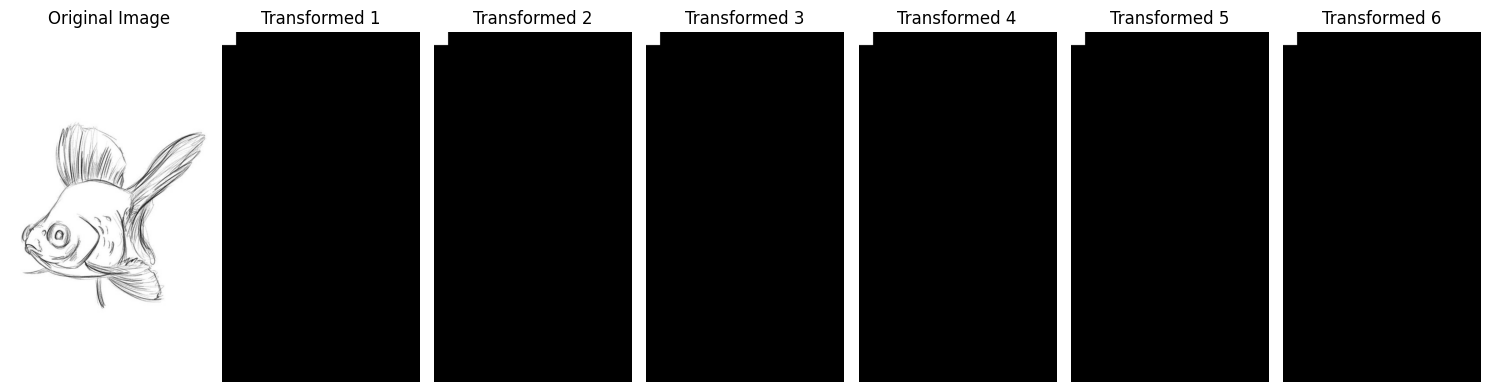

In [8]:
# 예시: 학습 이미지 중 하나를 선택하여 변환 및 시각화
image = cv2.imread('./data/train/n01443537/sketch_3.JPEG', cv2.IMREAD_COLOR)  # 원본 스케치 이미지 경로
visualize_bpd(image, num_deformations=6)